# Topological Data Analysis with Persistent Homology, $2^\text{nd}$ tutorial
https://raphaeltinarrage.github.io/EMAp.html
## Lesson VIII: Datasets have topology
Last update: 03/02/2021

### Student: Lucas Machado Moschen

In [47]:
import gudhi 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
' Functions of Tutorial 1 ' 

def PrintSimplices(simpcomplex):
    '''
    Print a list of the simplices of the simplicial complex 'simpcomplex'.
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        
    Example:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        PrintSimplices(simpcomplex)
    '''
    simplices = {i:[] for i in range(simpcomplex.dimension()+1)}
    for filtration in simpcomplex.get_simplices():
        simplex = filtration[0]
        simplices[len(simplex)-1].append(simplex)
    print('The simplicial complex contains the following simplices: ')
    for i in range(simpcomplex.dimension()+1):
        print('Dimension '+repr(i)+': ', end="")
        print(*simplices[i], sep = ", ")
        
def DrawSimplicialComplex(simpcomplex, pos=None):
    '''
    Draw the 1-skeleton of the simplicial complex 'simpcomplex', in the plane.
    If 'pos==None', the position of the vertices are chosen at random, according to the 'spring_layout' of networkx.
    If pos is a dict 
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        pos: a dict {(vertex of simpcomplex): (list of floats of length 2) }
        
    Example 1:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        DrawSimplicialComplex(simpcomplex)

    Example 2:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        pos = {0:[0,0], 1:[0,1]}
        DrawSimplicialComplex(simpcomplex, pos=pos)
    '''
    nodes=[]; edges=[]
    for filtr in simpcomplex.get_skeleton(1):
        simplex = filtr[0]
        if len(simplex)==1:
            nodes.append(simplex[0])
        if len(simplex)==2:
            edges.append(simplex)
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    if pos == None:
        pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, font_weight='bold', node_color='magenta')
    
def NumberOfConnectedComponents(simpcomplex, verbose = 'True'):
    '''
    Print the number of connected components of the simplicial complex 'simpcomplex'.
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        
    Example:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        NumberOfConnectedComponents(simpcomplex)
    '''    
    simpcomplex.compute_persistence()
    nbr_components = simpcomplex.betti_numbers()[0]
    if verbose: print('The simplicial complex admits '+repr(nbr_components)+' connected component(s).')
    return nbr_components

def EulerCharacteristic(simpcomplex, verbose = 'True'):
    '''
    Print the Euler characteristic of the simplicial complex 'simpcomplex'.
    
    Input: 
        simpcomplex: a gudhi.SimplexTree
        
    Example:
        simpcomplex = gudhi.SimplexTree()
        simpcomplex.insert([0])
        simpcomplex.insert([1])
        EulerCharacteristic(simpcomplex)
    '''
    num_simplices = [0 for i in range(simpcomplex.dimension()+1)]
    for filtration in simpcomplex.get_simplices():
        simplex = filtration[0]
        num_simplices[len(simplex)-1]+=1
    Euler_characteristic = sum(num_simplices[::2]) - sum(num_simplices[1::2])
    if verbose: print('The simplicial complex has Euler characteristic equal to '+repr(Euler_characteristic)+'.')
    return Euler_characteristicdata

In [3]:
' Functions of Tutorial 2 '

def SampleOnCircle(N = 100, sd = 0):
    '''
    Sample N_observation points from the uniform distribution on the unit circle 
    in R^2, with Gaussian noise of standard deviation sd.
        
    Input: 
        N (int): number of sample points on the circle.
        N_noise (float, optional): standard deviation of the Gaussian noise
    
    Output : 
        data (np.array): size Nx2, the points concatenated.
    '''
    rand_uniform = np.random.rand(N)*2-1    
    X = np.cos(2*np.pi*rand_uniform)
    Y = np.sin(2*np.pi*rand_uniform)
    data = np.stack((X,Y)).transpose() + np.random.normal(0, sd,  (N, 2))
    return data

def BettiNumbers(st, verbose = 'True'):
    '''
    Print the Betti numbers of the simplicial complex 'st'.
    
    Input: 
        st: a gudhi.SimplexTree
        
    Example:
        st = gudhi.SimplexTree()
        st.insert([0])
        st.insert([1])
        BettiNumbers(st)
    '''    
    if st.dimension()==0:
        betti_numbers = [st.num_simplices()]
    else:
        st.compute_persistence()
        betti_numbers = st.betti_numbers()
    if verbose: 
        print('The Betti numbers are:')
        for i in range(len(betti_numbers)):
            print('Beta_'+repr(i)+' = '+repr(betti_numbers[i]))
    return betti_numbers

def PlotThickening(X,t):
    '''
    Plot a matplotlib figure representing the t-thickening of the point cloud X. 
    X must be a point cloud in the plane.
    
    Input: 
        X (np.array): size Nx2, the points concatenated.
        
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        PlotThickening(X, 0.2)
    '''
    if np.shape(X)[1]!=2:
        print('Error! X is not in R^2')
        return False 
    N=np.shape(X)[0]
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot()
    for i in range(N):
        circle = plt.Circle((X[i,0], X[i,1]), t, color='magenta', alpha = 0.3)
        ax.add_artist(circle)
    for i in range(N):
        point = plt.Circle((X[i,0], X[i,1]), 0.02, facecolor='black', edgecolor = 'black', alpha = 1)
        ax.add_artist(point)
    bound = np.max(np.abs(X))+t    
    plt.xlim(-bound, bound); plt.ylim(-bound, bound)
    plt.axis('off')
    plt.show()

def GetBettiCurvesFromPointCloud(X, J, dim=3):
    '''
    Computes the Betti curves of the Rips complex on the point cloud X, 
    on the interval J, up to dimension dim.

    Input:
        X (np.array): size Nx2, the point cloud.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  
                                
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromPointCloud(X, J, dim = 2)
    '''
    I = 2*J
    tmax = max(I)
    rips = gudhi.RipsComplex(X, max_edge_length = tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))

def GetBettiCurvesFromDistances(D, J, dim=2):
    '''
    Computes the Betti curves of the Rips complex of the distance matrix D, 
    on the interval J, up to dimension dim.

    Input:
        D (np.array): size NxN, the distance matrix.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  

    Example:
        D = np.asarray([[0,1,2],[1,0,3],[2,3,0]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromDistances(D, J, dim = 1)
    '''
    I = 2*J
    tmax = max(I)
    rips = gudhi.RipsComplex(distance_matrix = D, max_edge_length = tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))

## Homology of the circle

We start with a circle

In [4]:
N = 50
X = SampleOnCircle(N)

Graphical representation with `matplolib`

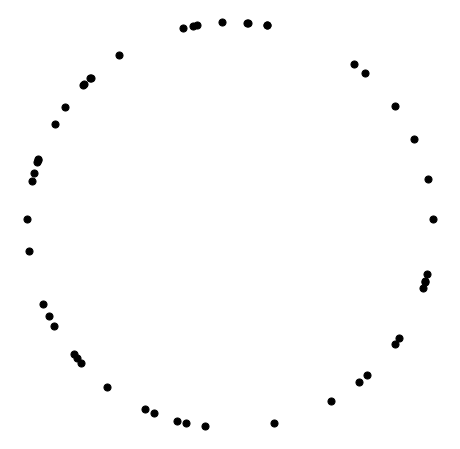

In [5]:
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(1, 1, 1)

plt.scatter(X[:,0],X[:,1], c='black', s=50)

plt.axis('equal'); plt.axis('off'); plt.show()

We will build the Rips complex of $X$ at time $t$.

In [6]:
t = 0.1

# adding the 0-simplices (vertices)
st = gudhi.SimplexTree()
for i in range(N):
    st.insert([i])
    
# adding the 1-simplices (edges)
for i in range(N):
    for j in range(i):
        if np.linalg.norm(X[i,:]-X[j,:])<=2*t:
            st.insert([i,j])

# computing the clique complex (up to the 2-simplices)           
st.expansion(2)

Now we can read the Betti numbers:

In [7]:
BettiNumbers(st)

The Betti numbers are:
Beta_0 = 11
Beta_1 = 0


[11, 0]

When $X$ is a subset of the plane, we can visualize the thickenings thanks to the function `PlotThickening`.

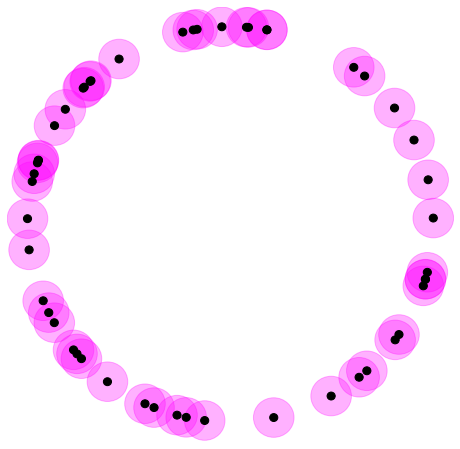

In [8]:
PlotThickening(X,t)

Let's try the same experiment with another value of $t$.

The Betti numbers are:
Beta_0 = 1
Beta_1 = 0


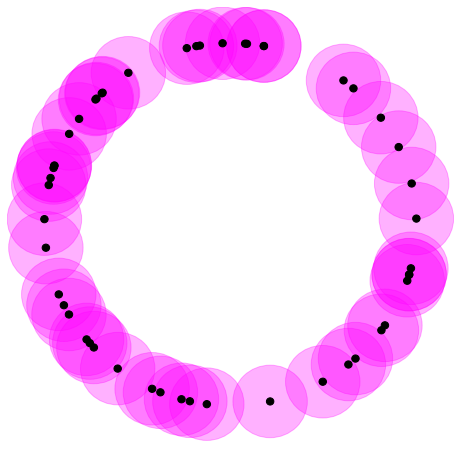

In [9]:
t = 0.2

# adding the 0-simplices (vertices)
st = gudhi.SimplexTree()
for i in range(N):
    st.insert([i])
    
# adding the 1-simplices (edges)
for i in range(N):
    for j in range(i):
        if np.linalg.norm(X[i,:]-X[j,:])<=2*t:
            st.insert([i,j])

# computing the clique complex (up to the 2-simplices)           
st.expansion(2)

BettiNumbers(st)

PlotThickening(X,t)

Now we compute the Betti curves of the points cloud $X \subset \mathbb{R}^2$.

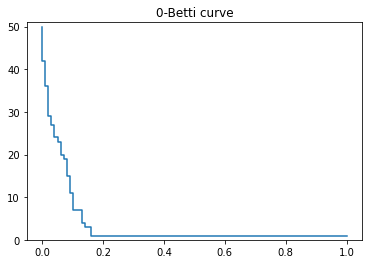

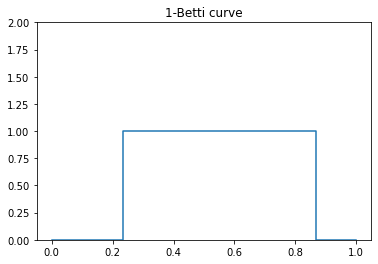

In [10]:
I = np.linspace(0,1,100)
Betti_curves = GetBettiCurvesFromPointCloud(X, I) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('1-Betti curve')
plt.show()

We observe that there exists a whole interval $I \subset [0,1]$ on which the thickenings have the homology of a circle.

<span style="color:darkblue">**Remark:**</span> with `Gudhi`, we can also obtain the Rips complex at time $t$ from a point cloud $X$ as follows:
```
t = 0.8
rips = gudhi.RipsComplex(X, max_edge_length = 2*t)
st = rips.create_simplex_tree(max_dimension=2)

```

## Homology of the noisy circle

We now repeat the same experiment with a *noisy* sample of the circle.

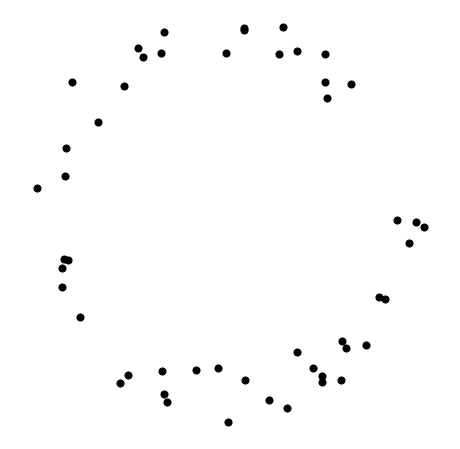

In [11]:
N = 50
sd = 0.1

X = SampleOnCircle(N, sd)

# plotting the point cloud
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(1, 1, 1)
plt.scatter(X[:,0],X[:,1], c='black', s=50)
plt.axis('equal'); plt.axis('off'); plt.show()

We build the Rips complex at time $t$, compute its Betti numbers and plot the thickening.

The Betti numbers are:
Beta_0 = 16
Beta_1 = 0


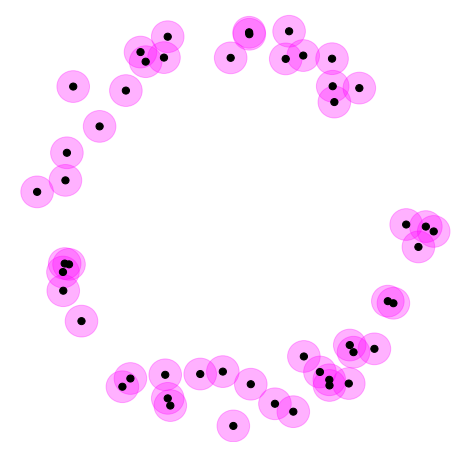

In [12]:
t = 0.09

# adding the 0-simplices (vertices)
st = gudhi.SimplexTree()
for i in range(N):
    st.insert([i])
    
# adding the 1-simplices (edges)
for i in range(N):
    for j in range(i):
        if np.linalg.norm(X[i,:]-X[j,:])<=2*t:
            st.insert([i,j])

# computing the clique complex (up to the 2-simplices)           
st.expansion(2)

BettiNumbers(st)

PlotThickening(X,t)

Now we compute the Betti curves of $X$. 
Observe that the $1$-Betti curve is less regular than in the previous example.

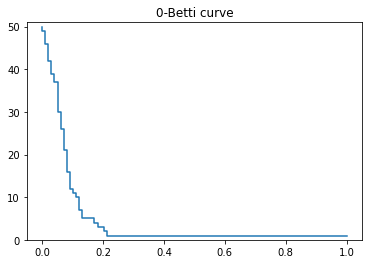

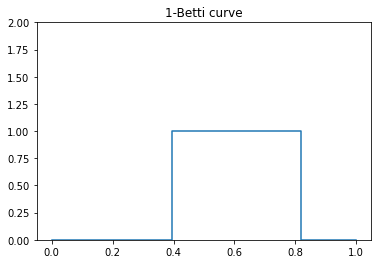

In [13]:
I = np.linspace(0,1,100)
Betti_curves = GetBettiCurvesFromPointCloud(X, I) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('1-Betti curve')
plt.show()

# Exercise 44

The following is a subset of $\mathbb{R}^4$ with $200$ elements. It has been sampled on a famous $2$-dimensional object. 

<span style="color:darkmagenta">**Question:**</span>
Compute the Betti curves of its Rips complex on $[0,1]$.
Can you recognize which surface it is?

We can observe that the betti curves stabilize in $\beta_1 = 2$ and $\beta_2 = 1$, so we can infer that it's a torus. However, the Klein Bottle has these values too and hence, we cannot answer the question. 

In [14]:
data = {0: [0.5400021775006532, 0.8416636194433932, -0.6822682946709439, 0.7311018903592044], 1: [-0.8026134821803633, 0.5964994536647218, 0.8493297809075483, -0.5278625988489202], 2: [0.7003005937894493, 0.7138480779116413, 0.7716492089313373, -0.6360483459263465], 3: [-0.9786166306406623, 0.205692708265309, -0.4897417926668873, 0.8718675223423703], 4: [0.5781950240767221, -0.8158985930450664, 0.8505465088386694, -0.5258998348567445], 5: [-0.8791159554953298, 0.4766079487309598, 0.9261490556218247, -0.37715769483175365], 6: [-0.7826176983514316, 0.6225026411406682, 0.3922940591205208, -0.9198398617035171], 7: [0.7961913290002486, 0.6050449302529672, -0.7193104891966963, 0.6946887217535704], 8: [-0.8834951174594977, 0.46844036698946895, -0.7683241450789192, -0.6400609409179315], 9: [-0.981199432932423, 0.19299656166131973, -0.9712088022254506, 0.23822985220120024], 10: [-0.5693176041915778, 0.8221176713570643, -0.9062099401921898, -0.4228280315883371], 11: [0.17133349881457016, 0.985213089734377, 0.3188508485615858, 0.9478049041715054], 12: [0.8327407852660222, 0.5536630604930481, 0.15425507167769917, 0.9880310586523624], 13: [-0.9966222631004077, 0.08212225455150195, 0.4630513921937395, -0.8863314324717586], 14: [-0.6875725679362158, 0.7261156683487817, -0.24208478136109446, 0.9702550997718853], 15: [0.9922304213281463, 0.12441378939237088, -0.8298669527155859, -0.5579613255330047], 16: [0.38433361555502354, -0.923194276387372, 0.41371480587789833, 0.9104065352343496], 17: [-0.5065965806860859, 0.8621832197608383, -0.1348431616221868, 0.9908669546229366], 18: [-0.0361567089318383, 0.9993461324282085, 0.32045398814176784, -0.9472640822305234], 19: [-0.9610742214843614, 0.27629031976931206, -0.9691289235638207, 0.24655451630832098], 20: [0.5640731614901023, 0.8257248140189085, -0.8114587054957744, 0.5844097614474986], 21: [-0.8792384106717147, 0.47638200763617966, 0.04093455010423245, -0.9991618300394407], 22: [0.7817436085356205, -0.6235999763580067, -0.36889646870272436, 0.9294704919354136], 23: [0.05858195491988199, 0.9982826025518851, -0.6547025084707521, 0.7558866485142496], 24: [0.6463602117886624, 0.7630324217335168, 0.4139661068912301, -0.9102922950049169], 25: [-0.33501710924416556, -0.9422120443475995, 0.7287356882518164, -0.6847950764047237], 26: [-0.7137374846960013, 0.7004133086541298, 0.5160526297762157, -0.8565568768628573], 27: [-0.9713664876757305, 0.23758608254802077, -0.16088288301164633, -0.9869735041802596], 28: [0.2202582242183198, 0.9754415998224559, -0.9750708174808401, 0.22189389558355638], 29: [0.743849817094733, -0.6683468033948635, 0.6022027455931742, -0.7983431926183392], 30: [-0.9674998557575348, 0.25287156643076586, -0.052356271448902314, -0.9986284698725392], 31: [-0.9965285195060417, 0.08325208592640032, -0.21182989645548017, -0.9773065511740217], 32: [-0.7748522156293235, -0.6321424237735737, -0.8567944258037608, 0.5156581347284303], 33: [0.5417562980726583, -0.8405356110829624, -0.9984997438877148, -0.05475638278929576], 34: [-0.9535261153849635, -0.3013103836227046, -0.7133941010795583, 0.7007630530677892], 35: [0.9100878489136783, -0.4144153800954712, 0.8954131089897818, -0.4452363015851844], 36: [0.4630310321282753, 0.886342069003962, -0.594643945637773, -0.8039891652978548], 37: [0.9443937279975954, 0.3288167978051058, 0.5055436893655878, -0.8628010072679737], 38: [0.3837266131167077, -0.9234467425823649, -0.22488441917661614, 0.9743854463258347], 39: [-0.06691301994026976, -0.9977588124203529, -0.886726908109613, 0.4622936192879651], 40: [-0.8374554544295875, 0.5465055917793825, -0.3985894054887749, -0.9171294814976264], 41: [-0.35094143430080094, 0.9363974101261155, 0.3983846514744652, -0.9172184415228298], 42: [-0.999985323459167, -0.005417828556257727, -0.010717933385150173, -0.9999425613023738], 43: [0.04755072620004681, -0.9988688244398501, 0.9357806308885601, -0.35258277163498564], 44: [0.8564484746445715, -0.5162325157126262, -0.9767055931253954, -0.2145837467227414], 45: [-0.41556011207261817, -0.9095657168419404, 0.66072566065051, 0.7506274717580933], 46: [-0.8157283776232888, -0.578435142379919, -0.2638715302833815, 0.9645578341944595], 47: [0.32836074390497716, 0.9445523923330934, 0.9670529035014827, -0.2545754933793749], 48: [0.7910825945356164, 0.6117093497918743, 0.9160986217446592, 0.4009530087647878], 49: [0.6856780539511739, -0.7279049431963841, 0.6802885692367758, 0.7329443789031883], 50: [-0.9730889467238255, 0.2304298196065689, -0.9831546849574074, 0.18277545088523509], 51: [0.964626748290962, 0.263619491846876, 0.5577408699263698, 0.8300151336052712], 52: [-0.37790381976087956, 0.9258448590396431, 0.5682352233999919, 0.8228661682725578], 53: [-0.38504851734033774, -0.9228963318238986, 0.9690039901463502, -0.24704507094951722], 54: [-0.658311155247941, 0.7527459218595085, 0.9680668962776582, 0.2506920109044998], 55: [-0.995685033540969, 0.09279716581081154, -0.9968644386789001, 0.07912831918726368], 56: [0.9942988078572735, 0.10662964265908711, 0.9969032939807477, 0.07863728409816156], 57: [0.21143023937285824, 0.9773930907668296, 0.9421383999122718, -0.33522415696179225], 58: [-0.7544287444428185, 0.6563819540164344, -0.46143927831732995, -0.8871717942010903], 59: [-0.9344650491469317, -0.35605487206724534, 0.9884222620789475, 0.15172815106873347], 60: [-0.244872045027763, 0.9695554040713307, 0.5653288259365284, -0.8248656366737714], 61: [-0.5766131218739391, -0.8170173239796019, -0.9973023218528374, 0.07340353415837335], 62: [-0.999861623118875, 0.016635342319553645, 0.8677793348687388, -0.4969497217775348], 63: [-0.4582119285533071, 0.8888429718074273, 0.8797782576498177, -0.47538428388688986], 64: [-0.360429772537355, 0.9327863523169014, -0.08085013695863692, 0.9967262690196189], 65: [-0.8140639874504145, -0.5807751925972142, -0.3653595174940193, -0.9308664904144619], 66: [-0.9594467985932399, 0.28188976687560496, -0.43797632460824604, 0.8989865066187881], 67: [0.8920527673047695, -0.4519312562148172, 0.1824919746003026, 0.9832073429376341], 68: [-0.6707634656700608, -0.7416713376707293, 0.3747570131963199, -0.9271230668364224], 69: [-0.9144254347190597, 0.404754400024087, 0.8193995397507423, -0.5732228137960593], 70: [-0.8718173414873371, -0.48983111689841824, -0.8794249546708074, 0.47603755009688925], 71: [-0.5777309149726426, 0.8162272905783493, 0.9794726541336494, -0.2015770815454587], 72: [0.994196362203701, 0.10758063664492522, -0.3814344263724101, -0.9243958991568225], 73: [0.44736248965252345, 0.8943527284309563, -0.7744296290333358, -0.6326600585427294], 74: [-0.5348633853990291, 0.8449385533631956, 0.32122233059877947, 0.9470038090338858], 75: [0.0818903217739068, 0.9966413473259906, 0.7643834514617666, 0.6447619243809277], 76: [0.6644681293736355, -0.7473166029513204, 0.6522799128837073, -0.7579781759710652], 77: [-0.6497166757921392, -0.7601764539878964, -0.3221442375611435, -0.9466905989847737], 78: [0.9941576678036071, -0.10793762804181309, 0.9954716172423985, 0.09505924081752162], 79: [-0.5207763956143086, 0.8536931215436664, -0.6604603388694422, 0.7508609330498301], 80: [-0.9968812402222557, -0.07891636644535444, 0.755938753460183, 0.6546423458783159], 81: [0.6080992869799383, -0.7938609810127278, -0.9751513937047076, 0.2215395209793645], 82: [0.9682868404436831, 0.24984113877340028, -0.7300761262723476, 0.683365824318983], 83: [0.9360615123361801, -0.3518363897082043, 0.8756249415632074, 0.4829916787196543], 84: [-0.3587198404209049, -0.9334452721442219, 0.15415861056647973, 0.9880461136952123], 85: [-0.07428806587451739, 0.9972368240636842, -0.9964007774949645, 0.08476727320983149], 86: [0.8749473754251763, -0.48421801932249026, 0.9510481348469547, -0.3090427886298733], 87: [0.9901461223134077, 0.14003805364158045, -0.9980524096043363, -0.062380988153268466], 88: [-0.3041090713948789, 0.9526372198771914, 0.9042248216335874, -0.4270567549421354], 89: [0.9983458215415766, -0.057494526787117105, -0.25394251272732776, -0.9672193134081489], 90: [-0.9504703340868105, 0.31081528923286084, 0.05721624246989065, 0.9983618089638779], 91: [0.9726910639340923, 0.23210362802585305, -0.700602900929682, -0.7135513823186905], 92: [0.7013886628943727, -0.712779028565827, 0.6630289406864811, 0.748593764208708], 93: [-0.964220436020806, -0.2651017743430752, -0.9999724445748382, 0.007423617111758388], 94: [-0.929873755605958, 0.36787878252934225, -0.952818563934601, -0.3035404161254391], 95: [-0.7647088819279465, -0.6443759197087597, -0.44289309241731395, 0.8965744300887845], 96: [0.23527742128976792, 0.9719282561131953, 0.6717389715383073, 0.7407879278961402], 97: [0.9473433390229902, -0.32021960903225755, 0.9001403186375336, 0.43560005367667193], 98: [0.6982230118449742, -0.7158803152274359, -0.9820028513343994, -0.18886609005088664], 99: [0.2780141563214674, -0.9605769770741243, 0.012189107043060267, -0.99992571007525], 100: [-0.3192202730518915, 0.9476805460030695, 0.9993850690946289, -0.03506399393571599], 101: [-0.9694342617584609, 0.24535120160461374, 0.5486854510913934, -0.8360288725640007], 102: [-0.7128032634738665, 0.7013640335667389, 0.7649286934834325, -0.6441149694625401], 103: [0.9988658398372691, -0.04761338053727205, -0.896904922143035, 0.44222342841101975], 104: [-0.08380063037403025, 0.9964825409152511, -0.862740681306464, -0.5056466323618288], 105: [0.5985808478130907, -0.8010623999610527, -0.4661719532740725, -0.8846941335742178], 106: [-0.3768862143069771, 0.9262595648441938, -0.7987408457923934, -0.6016752124384485], 107: [-0.31536337422007366, 0.948970991232361, -0.9091694359206924, -0.41642638819802225], 108: [0.9997555050649005, -0.022111763666106024, -0.6694798739360105, 0.7428301948592447], 109: [0.7045740476154122, -0.7096304752664128, 0.9340617985551146, -0.3571114062585854], 110: [0.29713287954760614, -0.9548361387650489, 0.3412714823947635, 0.9399647734378563], 111: [-0.5229439967523026, -0.8523670431573054, -0.05433152422988931, 0.9985229519018864], 112: [-0.3468971606634786, -0.9379031719338712, -0.8392821209089159, -0.5436961665513487], 113: [0.8932647072915808, 0.4495310475454242, 0.9857429706091668, 0.16825812281912345], 114: [-0.9925094855829784, 0.12216759401662823, 0.7551107655064597, 0.655597232922965], 115: [-0.937928854252422, 0.34682771567557696, -0.7293863293339368, -0.6841020264410609], 116: [0.5891508579674152, -0.8080230606587034, 0.23941083879175246, -0.9709183540695013], 117: [0.9955620389396931, -0.09410752691597545, -0.997597869625765, 0.06927113769915362], 118: [-0.6032550798753716, 0.7975483111414374, -0.684351038455518, -0.7291526974268518], 119: [0.9961103077427417, -0.08811500898632726, 0.9135454695351561, 0.4067366163646828], 120: [-0.7434799839419928, -0.6687581875966934, -0.5051262498238486, -0.8630454633093757], 121: [-0.988227541409148, 0.152991262497015, 0.7833547509327923, -0.6215748822073033], 122: [-0.8138427210139121, 0.5810852135897726, 0.9098697937868575, -0.414893912168233], 123: [0.11082130941970636, 0.993840348033074, -0.9644908868054028, -0.26411612837789294], 124: [0.6905875887256532, -0.7232487693028506, -0.5894945200710029, 0.807772375614726], 125: [-0.8943834662992748, -0.44730103421576606, -0.6659361143357748, 0.7460087744948916], 126: [0.40009230640345284, -0.9164748476400024, -0.03879618176341638, 0.9992471447447723], 127: [0.7215238439084081, -0.6923895887949465, 0.3712763340068234, -0.9285224196574112], 128: [0.6010091993977396, 0.7992421048964375, 0.3273610698996377, -0.9448993226339855], 129: [0.46907513625670755, 0.883158262456821, 0.1314758357831827, -0.9913193756832929], 130: [-0.7039351263200976, -0.710264273304457, -0.04224621595728018, -0.9991072300995979], 131: [0.03582592279353314, -0.9993580455752542, -0.009930103841114805, -0.9999506953033758], 132: [-0.5642083036666816, 0.825632478814615, -0.5452145628860876, -0.8382965348949811], 133: [-0.5612635649013784, -0.8276371250217067, -0.9075459297516433, 0.41995283710343634], 134: [0.8995542345516663, 0.43680908770327326, -0.9315445875222834, 0.3636271187053281], 135: [0.9829346128342233, 0.18395528503534617, 0.558422686567807, -0.8295565701785459], 136: [0.9535304959673295, -0.30129652049152267, 0.5737070696387799, -0.8190605583511418], 137: [0.9790248715195744, 0.2037407689837279, 0.992362135519995, -0.12335879371246786], 138: [0.3351068877887988, 0.9421801174703833, -0.39010178724135214, -0.9207717391357658], 139: [0.46623402961266697, -0.8846614209013157, -0.8439737783109, -0.5363844344531483], 140: [0.9635282186572051, 0.26760674851593946, 0.1422881244807212, -0.9898252823765207], 141: [-0.7814394249756893, -0.623981109564756, 0.06503365153954431, -0.9978830713903474], 142: [-0.9187780036735574, 0.39477459387051805, -0.8755489475582384, 0.4831294240984097], 143: [-0.6804102160995571, -0.7328314525369076, -0.6887636382471543, 0.7249859658148862], 144: [-0.994846454215113, 0.10139296097667261, -0.26777882206674947, 0.9634804110372687], 145: [-0.62231681276853, -0.7827654722492673, -0.9998843962088352, -0.015205072117328106], 146: [-0.898124111758587, -0.43974206061946036, 0.9349464420458026, -0.35478888159847227], 147: [0.1525763223469046, -0.9882916906759327, 0.6328820560007269, -0.7742482180749871], 148: [0.5139010878212042, 0.8578494459613429, -0.8344580915809221, -0.5510714049877071], 149: [0.7922257274701958, -0.6102281513780884, -0.5627605280272245, 0.8266199780398], 150: [0.8744485496024509, -0.48511826815547776, 0.6751998168195913, -0.7376348740174846], 151: [-0.7979518380491928, -0.6027212159480656, -0.6530955120871503, 0.7572755456844112], 152: [0.9769475786191761, -0.21347934005455596, -0.2234702933632543, 0.9747107406734272], 153: [-0.7819244350575288, 0.6233732251708958, 0.3243747712748298, -0.9459286483453189], 154: [0.5655571218625955, 0.8247091256379411, -0.7347050561635936, -0.6783866747273642], 155: [-0.9801960682986571, 0.1980294616764241, -0.9574218725612147, 0.2886924972031265], 156: [-0.437314329854761, -0.8993087216877647, 0.5664669406308963, 0.8240844648288624], 157: [-0.3202787321198973, -0.9473233522676779, -0.868559453744315, -0.4955849829356991], 158: [0.01103437898217967, 0.9999391193870143, 0.13581239696328545, -0.9907345723406885], 159: [0.7060777112870961, -0.708134355630043, 0.89883649274261, -0.43828410798723233], 160: [-0.1074810976197676, -0.9942071281450611, 0.25820849006092844, 0.966089217236408], 161: [0.6956663212514669, 0.7183650669934131, -0.707275330363608, -0.7069381918237614], 162: [0.9649301308697548, -0.2625068428435302, -0.2985171138237701, -0.954404281609385], 163: [-0.5788221039842223, 0.8154538441501629, 0.7587051083134657, 0.6514342319981752], 164: [-0.3932029833904468, 0.9194516919625805, -0.019570077035758127, 0.9998084877039275], 165: [0.6161941940179063, -0.7875942580152695, -0.44705748431510617, -0.8945052295642819], 166: [0.21450309226407058, 0.9767233095453142, 0.5351652971217873, 0.8447473614972403], 167: [-0.8033805471846226, 0.5954659489889714, 0.964023676829886, 0.2658163849565853], 168: [-0.3979892629841222, 0.9173900732781859, 0.4419667332577926, 0.8970314413070677], 169: [-0.10120976164649752, -0.994865108518466, -0.9551870187015457, -0.2960029717824687], 170: [-0.7263894067644691, 0.6872833693174619, 0.810294551082433, 0.5860228156702761], 171: [0.9578881190747057, -0.2871416920886313, 0.6432778213367154, 0.765632839274994], 172: [0.06192510407279702, 0.9980807990766947, 0.9078099240795017, 0.4193818567162502], 173: [-0.8413834204707132, 0.5404386549433736, -0.01820365031134937, 0.9998342998293978], 174: [0.5280594105597606, 0.8492074298540246, -0.877467818142277, -0.47963551591248094], 175: [-0.614633806020868, 0.7888125788147029, 0.9999951714971745, -0.003107568557007443], 176: [-0.15249597568888076, -0.9883040915622561, -0.9014654894421261, 0.43285098052894383], 177: [-0.1052047148063776, 0.9944505859933458, -0.7629334279169109, 0.6464770564892088], 178: [-0.9965415490812463, -0.08309597435947187, 0.9559700283851309, -0.2934643161090154], 179: [0.8982013848444748, -0.43958420383752167, -0.9388693174062326, 0.3442737353228603], 180: [-0.7404910538825619, 0.6720662163209015, -0.4100106157759109, 0.9120807502359966], 181: [0.9908177622163056, 0.13520414962815477, 0.808192442784989, -0.5889184794394147], 182: [0.30254737541538096, 0.9531343481531156, 0.1658344256334374, -0.9861536103847249], 183: [0.8303825405406406, -0.5571937152959204, -0.7689543124552884, -0.6393037348212621], 184: [0.36172077174026623, -0.9322864813412378, -0.933054764560394, -0.35973435522778135], 185: [-0.7873803134759683, 0.6164675514173361, 0.9894374992109437, -0.14496011573944684], 186: [0.023719756135542835, 0.9997186470046812, -0.9871290773427026, 0.15992555975998546], 187: [0.39047707196472153, -0.9206126526774753, -0.5078965394642982, -0.8614180780551279], 188: [0.9153522745596832, 0.40265396242731116, -0.46988929044746236, 0.8827253563384142], 189: [-0.9337344394406183, -0.357966474132026, 0.908498600084233, 0.4178878960259424], 190: [0.3479336083912797, -0.9375191753515357, 0.4772374489826721, -0.878774383609645], 191: [0.5621450033127129, 0.8270386902984346, -0.8792040448041527, 0.4764454298238335], 192: [-0.17451561581266667, -0.984654406295694, -0.9755538309675744, -0.21976060357691346], 193: [0.9645006419703611, 0.2640805021934814, 0.8611458881146055, 0.5083579048104861], 194: [0.8295943045886103, -0.5583666266837052, 0.9325710815369744, 0.3609863957006661], 195: [-0.6190863762900065, -0.7853229009089882, 0.42787412611765785, -0.9038383329993538], 196: [0.050765260797949005, -0.9987106128884965, -0.9312053495641041, -0.36449498891369503], 197: [0.2671785084379736, 0.9636470539719715, -0.11822660402663424, -0.9929866414510969], 198: [0.4217166802977216, -0.906727655671023, -0.9894993643513214, -0.14453721994120036], 199: [-0.997410490054251, 0.07191880372850229, 0.7337491537513641, -0.6794204731748648]}

In [15]:
data = np.array(list(data.values()))

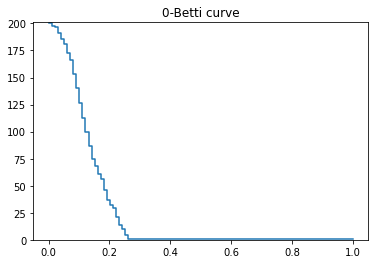

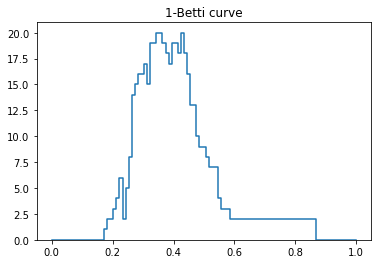

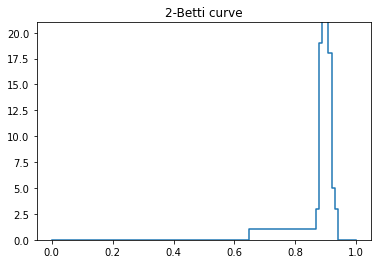

In [16]:
I = np.linspace(0,1,100)
Betti_curves = GetBettiCurvesFromPointCloud(data, I) 

plt.figure()
plt.step(I, Betti_curves[0])
plt.ylim(0, max(Betti_curves[0])+1)
plt.title('0-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[1])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('1-Betti curve')
plt.show()

plt.figure()
plt.step(I, Betti_curves[2])
plt.ylim(0, max(Betti_curves[1])+1)
plt.title('2-Betti curve')
plt.show()

# Exercise 45

The following collection of images comes from https://www.cs.columbia.edu/CAVE/software/softlib/coil-20.php

Each of the files `cloud1.txt`, ..., `cloud20.txt` in the folder `./Tutorial2` contain $72$ images of size $128\times128$ pixels. These images are different views of a same object.

|   |   |   |   |   |
|---|---|---|---|---|
| ![SegmentLocal](../data/tutorial-2/obj1.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj2.gif "segment") |![SegmentLocal](../data/tutorial-2/obj3.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj4.gif "segment") |![SegmentLocal](../data/tutorial-2/obj5.gif "segment") |
| ![SegmentLocal](../data/tutorial-2/obj6.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj7.gif "segment") |![SegmentLocal](../data/tutorial-2/obj8.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj9.gif "segment") |![SegmentLocal](../data/tutorial-2/obj10.gif "segment") |
| ![SegmentLocal](../data/tutorial-2/obj11.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj12.gif "segment") |![SegmentLocal](../data/tutorial-2/obj13.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj14.gif "segment") |![SegmentLocal](../data/tutorial-2/obj15.gif "segment") |
| ![SegmentLocal](../data/tutorial-2/obj16.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj17.gif "segment") |![SegmentLocal](../data/tutorial-2/obj18.gif "segment")|  ![SegmentLocal](../data/tutorial-2/obj19.gif "segment") |![SegmentLocal](../data/tutorial-2/obj20.gif "segment") |


You can access to the $i^\text{th}$ object by calling `OpenDataset(i)`.

The output, `matrix`, is a $72\times 16384$ matrix. 

For every $j \in [ 0,71]$, `matrix[j,:]` is the $j^\text{th}$ picture of the $i^\text{th}$ object.
It has been preprocessed as follows: the $128\times 128$-image has been converted into a $16384$-array.

In [17]:
def OpenDatasetEx45(i):
    file = '../data/tutorial-2/cloud'+str(i)+'.txt'
    matrix = open(file).read()
    matrix = np.asarray([[float(a) for a in item.split()] for item in matrix.split('\n')[:-1]])
    return matrix

For instance, we open the second object below, and print its third view.

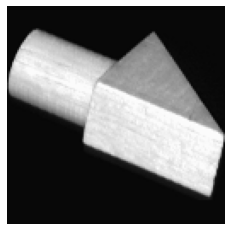

In [18]:
matrix = OpenDatasetEx45(2)

image = np.reshape(matrix[2], (128,128))
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.axis('off'); plt.show()

<span style="color:darkmagenta">**Question:**</span> 
- For some $i$'s in $[1,20]$, compute the Betti curves of the set $X \subset \mathbb{R}^{16384}$ defined as follows: $X$ consists in $72$ points, the different views of the $i^\text{th}$ object.
- Guess the topology of the underlying object for $i=1,4, 7,10, 13$ and $20$.

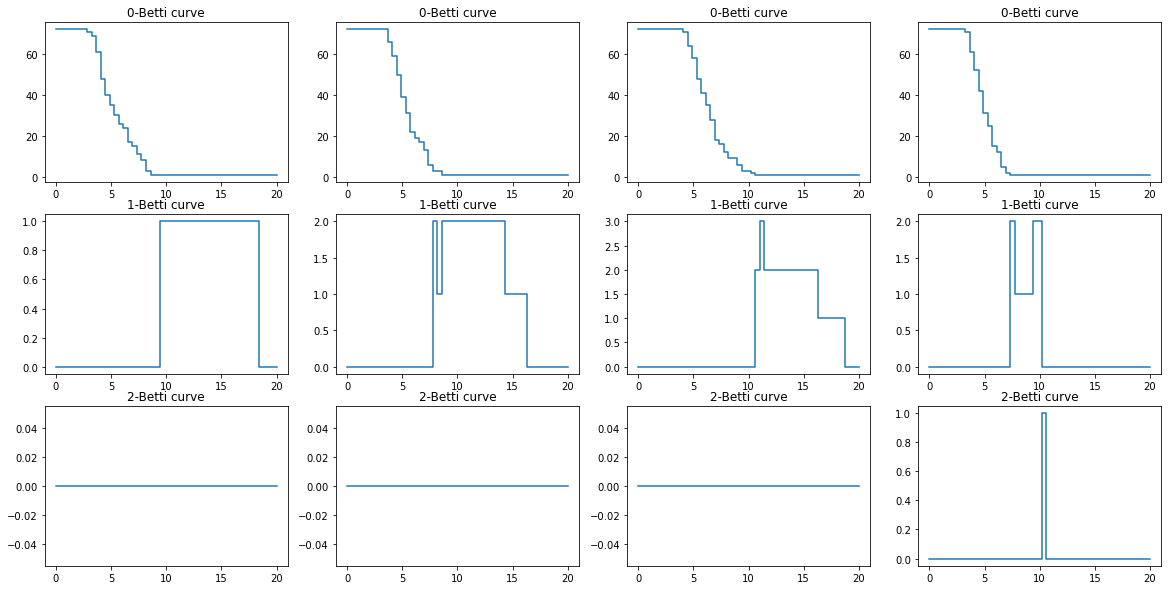

In [19]:
fig, ax = plt.subplots(3,4,figsize = (20,10))

chosen_pics = [4,10,13,20]

for index in range(4):
    
    X = OpenDatasetEx45(chosen_pics[index])
    I = np.linspace(0,20,50)
    Betti_curves = GetBettiCurvesFromPointCloud(X, I) 

    ax[0][index].step(I, Betti_curves[0])
    ax[0][index].set_title('0-Betti curve')
    
    ax[1][index].step(I, Betti_curves[1])
    ax[1][index].set_title('1-Betti curve')

    ax[2][index].step(I, Betti_curves[2])
    ax[2][index].set_title('2-Betti curve')
    
plt.show()

Above one can see the Betti Numbers from four objects, each one correspond to the objects below. It's clear $\beta_2 = 0$ for all of them because of the dimension we have chosen (dim = 3). The first seems a circle, the second two connected circles, as the third and the fourth a circle. 

![SegmentLocal](../data/tutorial-2/obj4.gif "segment") | ![SegmentLocal](../data/tutorial-2/obj10.gif "segment") | ![SegmentLocal](../data/tutorial-2/obj13.gif "segment") | ![SegmentLocal](../data/tutorial-2/obj20.gif "segment")

# Exercise 46

Paper available at https://arxiv.org/pdf/1412.1394.pdf

Data from https://www.researchgate.net/publication/301543862_corr

> The maltose-binding protein (MBP) is a bacterial protein found in Escherichia coli where its primary
function is to bind and transport sugar molecules across cell membranes, providing energy
to the bacterium 

> While performing biological functions, the MBP changes its structure. Our objects of
study are **fourteen three-dimensional structures of the MBP**, obtained by X-ray crystallography. The structures are available from the Protein Data Bank, Bernstein et al. (1977). Each
structure is a large biomolecule with about 3000 heavy atoms **grouped into 370 relatively
small clusters representing amino acid residues.**

> A major conformational change in the protein occurs when a smaller molecule called a
ligand attaches to the protein molecule, see Figure 1. Szmelcman et al. (1976) determined
that the MBP interacts with various sugar molecules (ligands), starting from the small
maltose molecule through the larger maltodextrin. Ligand-induced conformational changes
are important because the biological function of the protein occurs through a transition from
a ligand-free (apo) to a ligand-bound (holo) structure (Seeliger & de Groot, 2010).
Simulations and to some extent experiments show that 95% of the time the two domains
of MBP are separated and twisted, which is called an **open conformation**, and 5% of the
time they are close to each other, which is called a **closed conformation**.

<img src="../data/tutorial-2/MBP2.png" alt="Drawing" style="width: 800px;"/>

> We consider seven closed and seven open conformations.

<img src="../data/tutorial-2/MBP1.png" alt="Drawing" style="width: 800px;"/>

> One may attempt to use topological methods to describe the function of the MBP using the
spatial coordinates of the residues. This is not a novel idea; Edelsbrunner & Harer (2010)
studied computational ways of predicting protein interactions based solely on their shape.
Furthermore, Gameiro et al. (2012) defined a topological quantity based on persistence diagrams of several proteins and established correspondence with experimental compressibility
of the majority of investigated proteins. However, **this intuitive approach proves to be inefficient in distinguishing between the closed and the open MBP conformation.**

> Therefore, we do not analyze the geometry of the MBP structure directly. Instead we use the static crystallographic data to construct a dynamic model of the
protein structure from which we calculate **dynamical distances** between the residues. Our
subsequent analysis will use these dynamical distances and not the geometric distances

> [...] Taking into account the first twenty nontrivial modes of oscillation, we calculate **fourteen
cross-correlation matrices (C) of size 370 × 370** using the Anisotropic Network Model web
server (Eyal et al., 2006). Following Bradley et al. (2008), for each correlation matrix we
calculate the associated dynamical distance matrix (D) using a simple linear map, $$D_{i,j} = 1 − |C_{i,j} |$$

The correlation matrices are contained in the subfolder `./Tutorial2`.
We can use the function `OpenDatasetEx46`, for $i$ in $[1,7]$, and `structure` $=$ `closed` or  `open`.

In [20]:
def OpenDatasetEx46(i, structure):
    if structure == 'closed': file = '../data/tutorial-2/closed'+repr(i)+'.txt'
    if structure == 'open': file = '../data/tutorial-2/open'+repr(i)+'.txt' 
    corr = open(file).read()
    corr = np.asarray([[float(a) for a in item.split()] for item in corr.split('\n')[:-1]])
    return corr

Below, we load the correlation matrix of the first *closed* MBP.

In [22]:
corr = OpenDatasetEx46(1, 'closed')

corr.shape

(370, 370)

<span style="color:darkmagenta">**Question:**</span> 
- Load the correlation matrices of some proteins.
- Convert them into distance matrices via the formula $D_{i,j} = 1 − |C_{i,j} |$
- Compute their Betti curves with the function `GetBettiCurvesFromDistances`. Computing them on `I = np.linspace(0, 0.2, 100)` is enough.
- Compare the 1-Betti curves of several MBP. Do the Betti curves of MBP of a same structure (open or closed) seem closer?

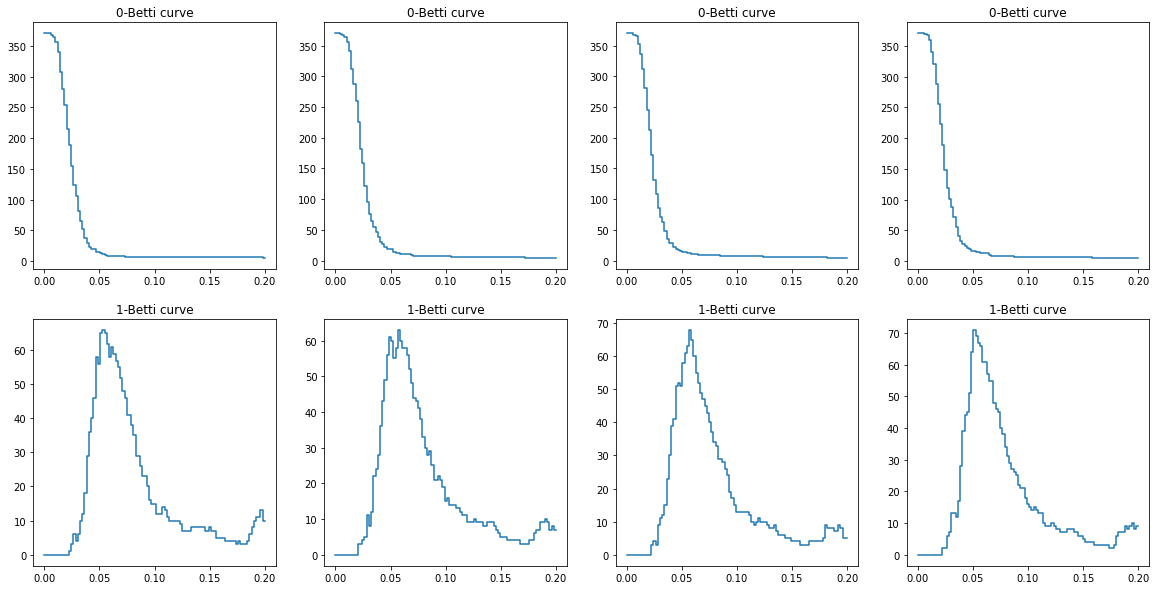

In [23]:
fig, ax = plt.subplots(2,4,figsize = (20,10))

chosen_molecs = [1,3,4,6]

for index in range(4):
    
    corr = OpenDatasetEx46(chosen_molecs[index], 'closed')
    matrix = 1-np.abs(corr)
    I = np.linspace(0, 0.2, 100)
    Betti_curves = GetBettiCurvesFromDistances(matrix, I, dim = 2)

    ax[0][index].step(I, Betti_curves[0])
    ax[0][index].set_title('0-Betti curve')
    
    ax[1][index].step(I, Betti_curves[1])
    ax[1][index].set_title('1-Betti curve')
    
plt.show()

In [41]:
def compare_proteins(proteins: list): 
    
    curves_closed = []
    I = np.linspace(0, 0.2,100)
    for i in proteins: 
        corr = OpenDatasetEx46(i, 'closed')
        dist = 1-np.abs(corr)
        curves_closed.append(GetBettiCurvesFromDistances(dist, I, dim = 2)) 
        
    curves_open = []
    for i in proteins: 
        corr = OpenDatasetEx46(i, 'open')
        dist = 1-np.abs(corr)
        curves_open.append(GetBettiCurvesFromDistances(dist, I, dim = 2)) 
        
    dist_closed = np.zeros(shape = (len(proteins), len(proteins)))
    dist_open = np.zeros(shape = (len(proteins), len(proteins)))
    dist_proteins = np.zeros(shape = (len(proteins),))

    
    for i in range(len(proteins)-1):
        for j in range(i+1,len(proteins)):
            dist_closed[i,j] = dist_closed[j,i] = np.linalg.norm(curves_closed[i][1] - curves_closed[j][1])
            dist_open[i,j] = dist_open[j,i] = np.linalg.norm(curves_open[i][1] - curves_open[j][1])
        dist_proteins[i] = np.linalg.norm(curves_open[i][1] - curves_closed[i][1])
        
    return dist_closed, dist_open, dist_proteins 

In [44]:
protein_closed, protein_open, same_protein = compare_proteins([1,2,3,4,5,6,7])

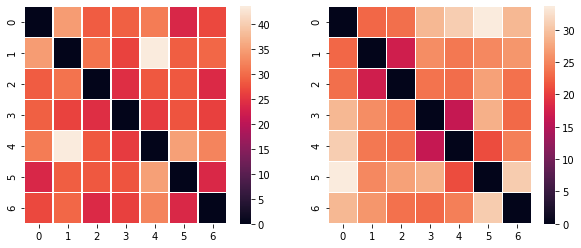

In [54]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
sns.heatmap(protein_closed, linewidth=0.5,ax=ax[0])
sns.heatmap(protein_open, linewidth=0.5,ax=ax[1])
plt.show()

In [55]:
print(same_protein)

[38.06573262 46.06517123 37.32291521 41.36423576 49.79959839 52.40229003
  0.        ]


> Hence, at the significance level $\alpha = 0.05$ we have compelling evidence that in the space of dynamical distances **the closed and
the open MBP conformation significantly differ both in the number of connected components
and the number of one dimensional loops**. Concerning the second homology group $H_2$, the
test $p$-value of $0.0396$ indicates moderate evidence of difference between closed and open
proteins at the level $\alpha = 0.05$.

> What can we infer from these results? In the space of dynamical distances the interpretation of results is not
as straightforward as when actual protein coordinates are used.
One may wonder about the meaning of the ‘number of connected components’ in this space;
since dynamical distances make the residues with (anti) correlated motion to cluster together, it seems reasonable that results in dimension $0$ apply to the **number of correlated
pieces**; similarly, the meaning of the one dimensional ‘loop’ could correspond to **‘a channel
of interaction.’** If so, then we have observed a statistically significant difference between the
two conformations in terms of the number of mutually correlated pieces and the number of
interaction channels between residues.

<span style="color:darkblue">**Remark:**</span> with `Gudhi`, we can also obtain the Rips complex at time $t$ from a distance matrix `matrix` as follows:
```
t = 0.8
rips = gudhi.RipsComplex(distance_matrix = matrix, max_edge_length = 2*t)
st = rips.create_simplex_tree(max_dimension=2)

```